# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Постановка задачи**<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.

**Примерное описание этапов выполнения курсового проекта**<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Библиотеки. Функции

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

In [4]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

**Загрузка данных**

In [55]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# Обзор датасета

In [56]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [57]:
df_train.shape

(7500, 17)

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_test.shape

(2500, 16)

Количество уникальных значений

In [10]:
df_train.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [11]:
df_test.nunique()

Home Ownership                     4
Annual Income                   1929
Years in current job              11
Tax Liens                          8
Number of Open Accounts           35
Years of Credit History          345
Maximum Open Credit             2435
Number of Credit Problems          8
Months since last delinquent      83
Bankruptcies                       6
Purpose                           14
Term                               2
Current Loan Amount             2026
Current Credit Balance          2385
Monthly Debt                    2416
Credit Score                     211
dtype: int64

## Обзор категориальных переменных

In [12]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [13]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [14]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [15]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

---

# Baseline

Decision Tree Classifier

Обновляем датасет

In [153]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Заполняем пропуски медианой

In [59]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
#df_train = df_train.fillna(df_train.mode()[0:])
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Переводим категориальные признаки в количественные

In [155]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_train.nunique()

Annual Income                     5478
Tax Liens                            8
Number of Open Accounts             39
Years of Credit History            408
Maximum Open Credit               6963
Number of Credit Problems            8
Months since last delinquent        89
Bankruptcies                         5
Current Loan Amount               5386
Current Credit Balance            6592
Monthly Debt                      6716
Credit Score                       268
Credit Default                       2
Home Ownership_Have Mortgage         2
Home Ownership_Home Mortgage         2
Home Ownership_Own Home              2
Home Ownership_Rent                  2
Years in current job_1 year          2
Years in current job_10+ years       2
Years in current job_2 years         2
Years in current job_3 years         2
Years in current job_4 years         2
Years in current job_5 years         2
Years in current job_6 years         2
Years in current job_7 years         2
Years in current job_8 ye

Формируем выборки

In [156]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

In [21]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

Подбираем гиперпараметры

In [157]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

Wall time: 17 s


In [158]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 5}

Предсказываем значения трейновой и тестовой выборки

In [159]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [160]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.7786666666666666
Accuracy на тесте 0.7673333333333333


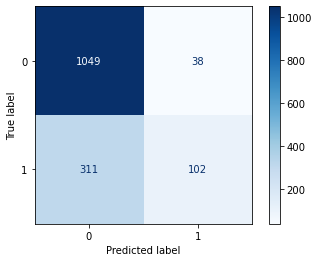

In [161]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [162]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1087
           1       0.73      0.25      0.37       413

    accuracy                           0.77      1500
   macro avg       0.75      0.61      0.61      1500
weighted avg       0.76      0.77      0.72      1500



In [163]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.369


Замена NaN на медиану F1 = 0.369


Вероятности предсказания классов.

In [40]:
# predict_proba возвращает вероятность
pred_proba_test = tree.predict_proba(X_test)

# выведем вероятности: 1-й столбец для нулевого клааса, 2-й - для первого класса
pred_proba_test[:5]

array([[0.89193825, 0.10806175],
       [0.76868132, 0.23131868],
       [0.57709251, 0.42290749],
       [0.81759657, 0.18240343],
       [0.76868132, 0.23131868]])

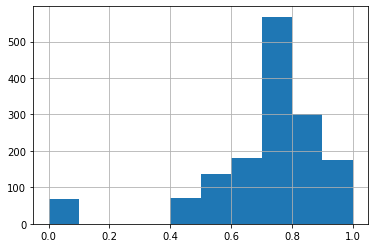

In [42]:
pd.Series(pred_proba_test[:,0]).hist();

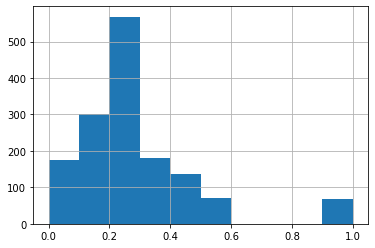

In [41]:
pd.Series(pred_proba_test[:,1]).hist();

Меняем отсечку вручную

In [81]:
pred_test = np.where(pred_proba_test[:,1] >= 0.2, 1, 0)

In [82]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.498


In [70]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1087
           1       0.43      0.59      0.50       413

    accuracy                           0.67      1500
   macro avg       0.62      0.65      0.63      1500
weighted avg       0.71      0.67      0.69      1500



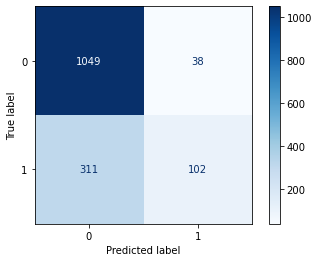

In [83]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

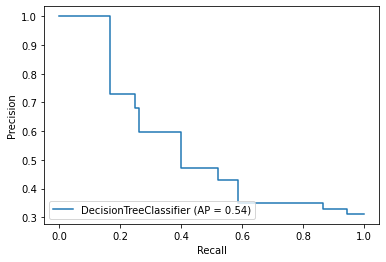

In [86]:
plot_precision_recall_curve(tree, X_test, y_test);

In [87]:
precision_recall_curve(y_test, pred_proba_test[:, 1])

(array([0.31169811, 0.33022862, 0.34926829, 0.43137255, 0.47045952,
        0.59566787, 0.67924528, 0.72857143, 1.        , 1.        ]),
 array([1.        , 0.94430993, 0.86682809, 0.58595642, 0.52058111,
        0.39951574, 0.26150121, 0.24697337, 0.16464891, 0.        ]),
 array([0.10806175, 0.18240343, 0.23131868, 0.27152318, 0.33245383,
        0.42290749, 0.46428571, 0.55780347, 1.        ]))

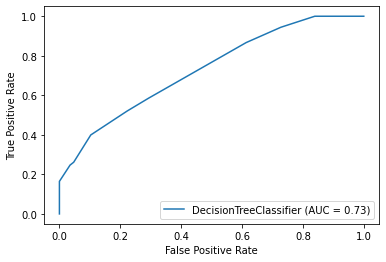

In [88]:
plot_roc_curve(tree, X_test, y_test);

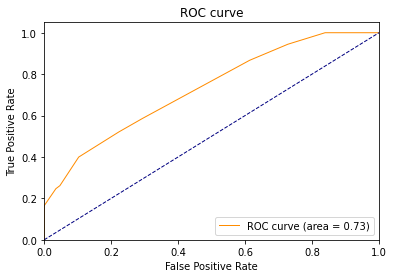

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Ниже пунктирной криваой падать нельзя, потому что ниже начинаются случайные значения.

---

## Baseline с отбором признаков

Обновляем датасет

In [352]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Выделение целевой переменной и групп признаков

In [91]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                           'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                           'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Корреляция с базовыми признаками

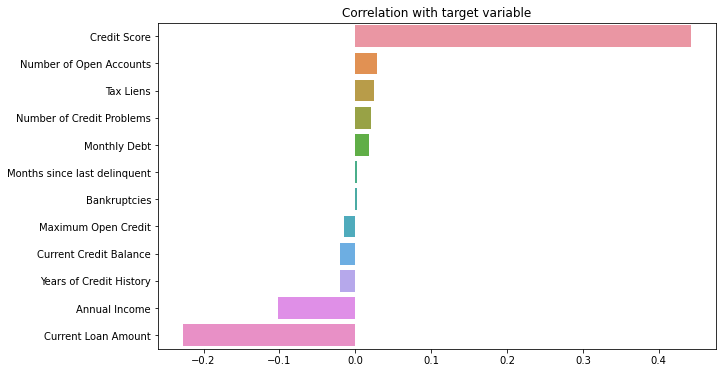

In [354]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Выбираем наиболее значимые признаки** [:кол-во признаков]

In [355]:
features = corr_with_target.sort_values(ascending=False, key=lambda x: abs(x))[:12]
features

Credit Score                    0.442050
Current Loan Amount            -0.226522
Annual Income                  -0.101375
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Years of Credit History        -0.020567
Number of Credit Problems       0.020088
Current Credit Balance         -0.019522
Monthly Debt                    0.018480
Maximum Open Credit            -0.014275
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Name: Credit Default, dtype: float64

Список выбранных признаков

In [356]:
features_names = features.index
features_names

Index(['Credit Score', 'Current Loan Amount', 'Annual Income',
       'Number of Open Accounts', 'Tax Liens', 'Years of Credit History',
       'Number of Credit Problems', 'Current Credit Balance', 'Monthly Debt',
       'Maximum Open Credit', 'Months since last delinquent', 'Bankruptcies'],
      dtype='object')

Оставляем в датасете только выбранные признаки

In [357]:
df_train = df_train[features_names]
df_train.head()

,Credit Score,Current Loan Amount,Annual Income,Number of Open Accounts,Tax Liens,Years of Credit History,Number of Credit Problems,Current Credit Balance,Monthly Debt,Maximum Open Credit,Months since last delinquent,Bankruptcies
0,749.0,99999999.0,482087.0,11.0,0.0,26.3,1.0,47386.0,7914.0,685960.0,NaN,1.0
1,737.0,264968.0,1025487.0,15.0,0.0,15.3,0.0,394972.0,18373.0,1181730.0,NaN,0.0
2,742.0,99999999.0,751412.0,11.0,0.0,35.0,0.0,308389.0,13651.0,1182434.0,NaN,0.0
3,694.0,121396.0,805068.0,8.0,0.0,22.5,1.0,95855.0,11338.0,147400.0,NaN,1.0
4,719.0,125840.0,776264.0,13.0,0.0,13.6,1.0,93309.0,7180.0,385836.0,NaN,0.0


In [358]:
df_test = df_test[features_names]
df_test.head()

,Credit Score,Current Loan Amount,Annual Income,Number of Open Accounts,Tax Liens,Years of Credit History,Number of Credit Problems,Current Credit Balance,Monthly Debt,Maximum Open Credit,Months since last delinquent,Bankruptcies
0,NaN,162470.0,NaN,9.0,0.0,12.5,0.0,105906.0,6813.0,220968.0,70.0,0.0
1,699.0,78298.0,231838.0,6.0,0.0,32.7,0.0,46037.0,2318.0,55946.0,8.0,0.0
2,7260.0,200178.0,1152540.0,10.0,0.0,13.7,0.0,146490.0,18729.0,204600.0,NaN,0.0
3,739.0,217382.0,1220313.0,16.0,0.0,17.0,0.0,213199.0,27559.0,456302.0,70.0,0.0
4,706.0,777634.0,2340952.0,11.0,0.0,23.6,0.0,425391.0,42605.0,1207272.0,NaN,0.0


Заполняем пропуски медианой

In [359]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
df_test = df_test.fillna(df_test.median(axis=0), axis=0)

Категориальных признаков нет, поэтому нечего переводить в количественные

Формируем выборки

In [360]:
X = df_train
y = pd.read_csv(TRAIN_DATASET_PATH)['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 12), (1500, 12))

Подбираем гиперпараметры

In [361]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

Wall time: 13.3 s


In [362]:
grid_search.best_params_

{'max_depth': 1, 'min_samples_leaf': 1}

Предсказываем значения трейновой и тестовой выборки

In [363]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [364]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.772
Accuracy на тесте 0.77


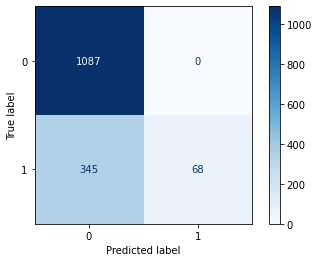

In [365]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [366]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1087
           1       1.00      0.16      0.28       413

    accuracy                           0.77      1500
   macro avg       0.88      0.58      0.57      1500
weighted avg       0.83      0.77      0.70      1500



In [367]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.283


Результаты исключение признаков - F1 score низкое и не меняется

|No features | F1 score|
|-|-|
|5 | 0.283|
|6|0.283|
|7|0.283|
|8|0.283|
|9|0.283|
|10|0.283|
|11|0.283|
|12|0.283|

# Обработка выбросов

# Обработка пропусков

https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

Идеи заполнения:
- knn https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
- медианной по группе. Например заполнить Annual Income по Years of Credit History

In [63]:
df_train.isna().sum()

Annual Income                     1557
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent      4080
Bankruptcies                        14
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                      1557
Credit Default                       0
Home Ownership_Have Mortgage         0
Home Ownership_Home Mortgage         0
Home Ownership_Own Home              0
Home Ownership_Rent                  0
Years in current job_1 year          0
Years in current job_10+ years       0
Years in current job_2 years         0
Years in current job_3 years         0
Years in current job_4 years         0
Years in current job_5 years         0
Years in current job_6 years         0
Years in current job_7 years         0
Years in current job_8 ye

Количество пропущенных значений по признакам:
```
Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
```

# Анализ данных

In [94]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

**Проверим распределения вещественных признаков на трейне и тесте**

Сравним их распределения

нам нужно чтобы p-value было больше 5% иначе он какой то странный и на нём лучше не обучаться.

Annual Income
MannwhitneyuResult(statistic=7437874.5, pvalue=1.1638872141183186e-54)


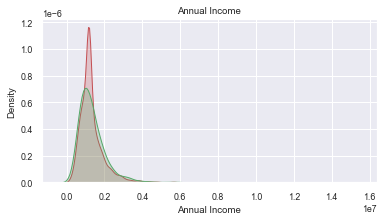

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


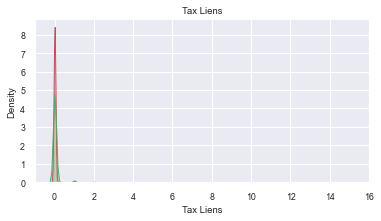

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


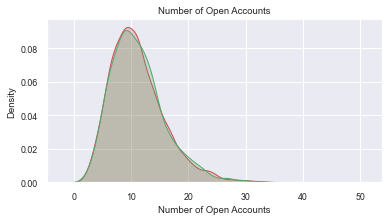

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


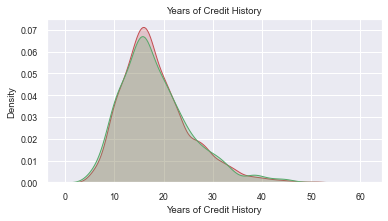

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


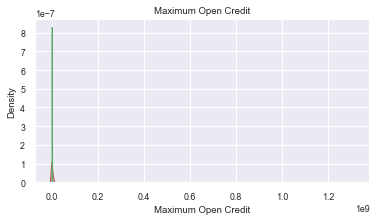

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


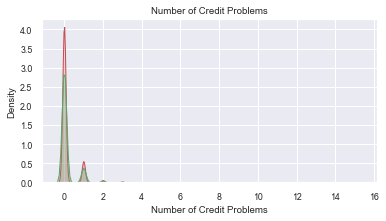

Months since last delinquent
MannwhitneyuResult(statistic=4446541.5, pvalue=0.0)


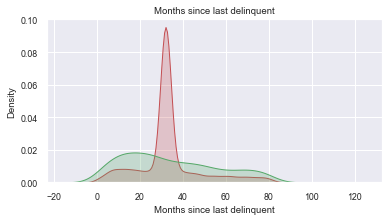

Bankruptcies
MannwhitneyuResult(statistic=9273462.0, pvalue=0.06499363911022255)


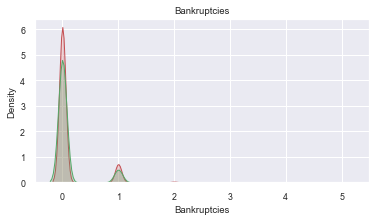

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


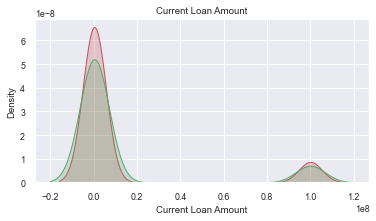

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


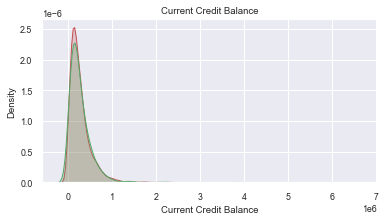

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


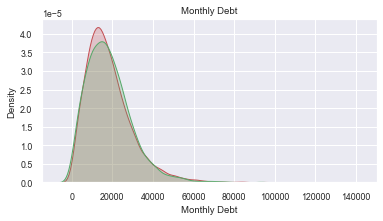

Credit Score
MannwhitneyuResult(statistic=7450960.5, pvalue=5.181190474654923e-54)


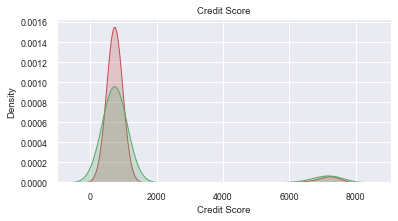

In [95]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.title(col)
    plt.show()

P-value < 0.05 имют признаки:
- Annual Income
- Months since last delinquent
- Credit Score

Построим модель без этих признаков:

{'max_depth': 5, 'min_samples_leaf': 5}
Accuracy на трейне 0.7786666666666666
Accuracy на тесте 0.7673333333333333
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1087
           1       0.73      0.25      0.37       413

    accuracy                           0.77      1500
   macro avg       0.75      0.61      0.61      1500
weighted avg       0.76      0.77      0.72      1500

F1-score = 0.369
Wall time: 17.1 s


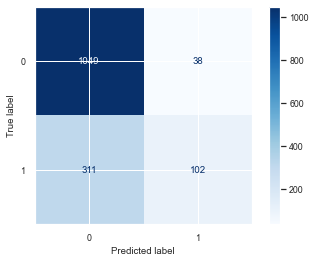

In [115]:
%%time

# Обновляем датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

df_train.drop(columns=['Annual Income', 'Months since last delinquent', 'Credit Score', 'Credit Default'])
df_test.drop(columns=['Annual Income', 'Months since last delinquent', 'Credit Score'])

# Заполняем пропуски медианой
df_train = df_train.fillna(df_train.median(axis=0), axis=0)

# Переводим категориальные признаки в количественные
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Формируем выборки
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

# Подбираем гиперпараметры
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

print(grid_search.best_params_)

# Предсказываем значения трейновой и тестовой выборки
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

#Подсчитываем метрики
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

print(classification_report(y_test, pred_test))
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Исключение 3-х признаков не увеличило скор.

Обновляем датасет

In [105]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

**Проверим распределения категориальных признаков на трейне и тесте**

Целевая переменная есть только на трейне и нам нужно как-то выкручиваться, чтобы понимать насколько выборки между собой похожи.

Years of Credit History имел самый высокий уровень значимости, значит в его разрезе будем смотреть на категории.

Нужно чтобы зелёные (тест) доверительные интервалы были похожи на красные (трейн).

Purpuse трейна имеет на 1 значение больше чем теста.

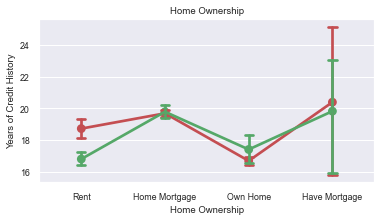

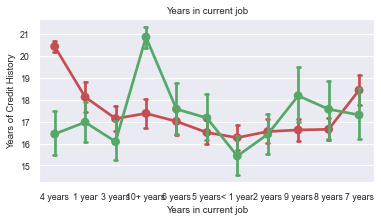

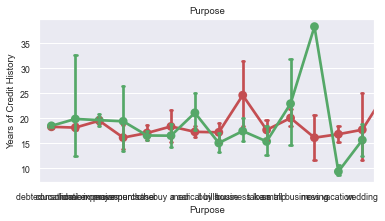

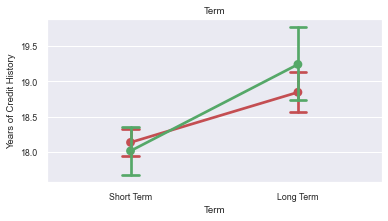

In [106]:
num_feature = 'Years of Credit History'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

Построим доверительные интервалы по признаку Maximum Open Credit.

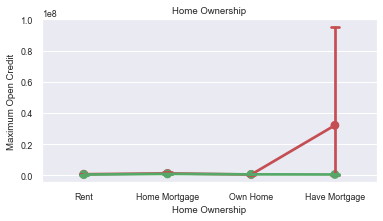

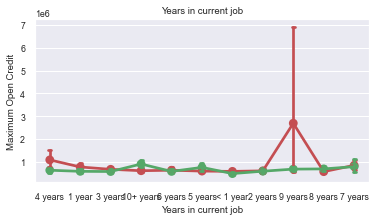

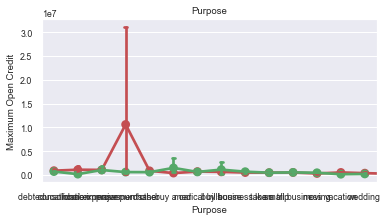

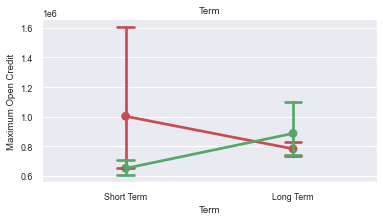

In [108]:
num_feature = 'Maximum Open Credit'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

Построим доверительные интервалы по признаку Current Credit Balance

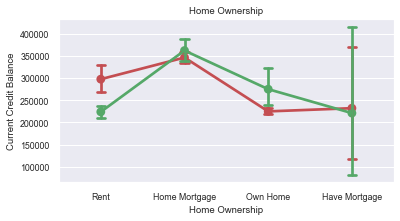

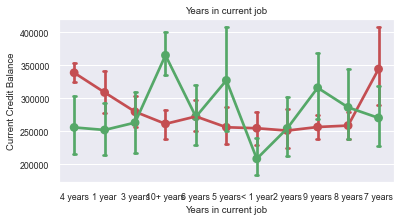

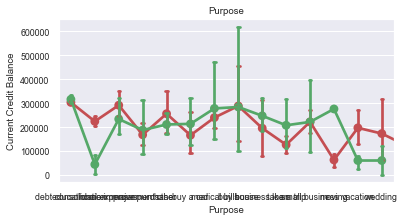

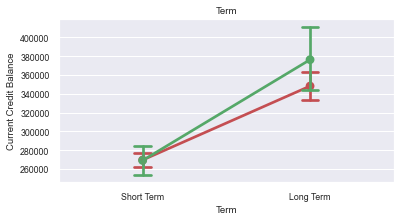

In [109]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

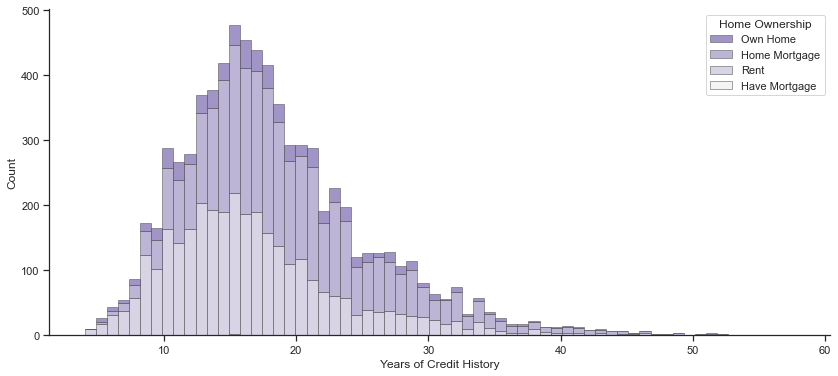

In [143]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)

sns.histplot(
    df_train,
    x="Years of Credit History", hue="Home Ownership",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

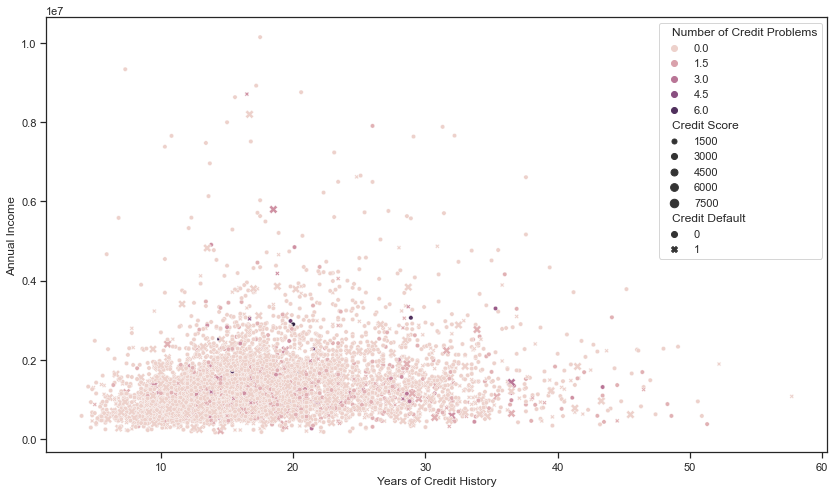

In [154]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.scatterplot(data=df_train, x="Years of Credit History", y="Annual Income",
                size='Credit Score', 
                style="Credit Default",
                hue='Number of Credit Problems',
               );

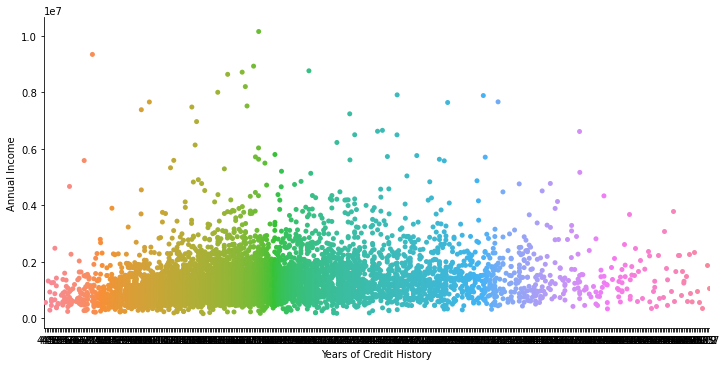

In [119]:
sns.catplot(x="Years of Credit History", y="Annual Income", 
            #kind="box", 
            data=df_train, aspect=2,
            #order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
            #      '6 years', '7 years', '8 years', '9 years', '10+ years']
           );

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

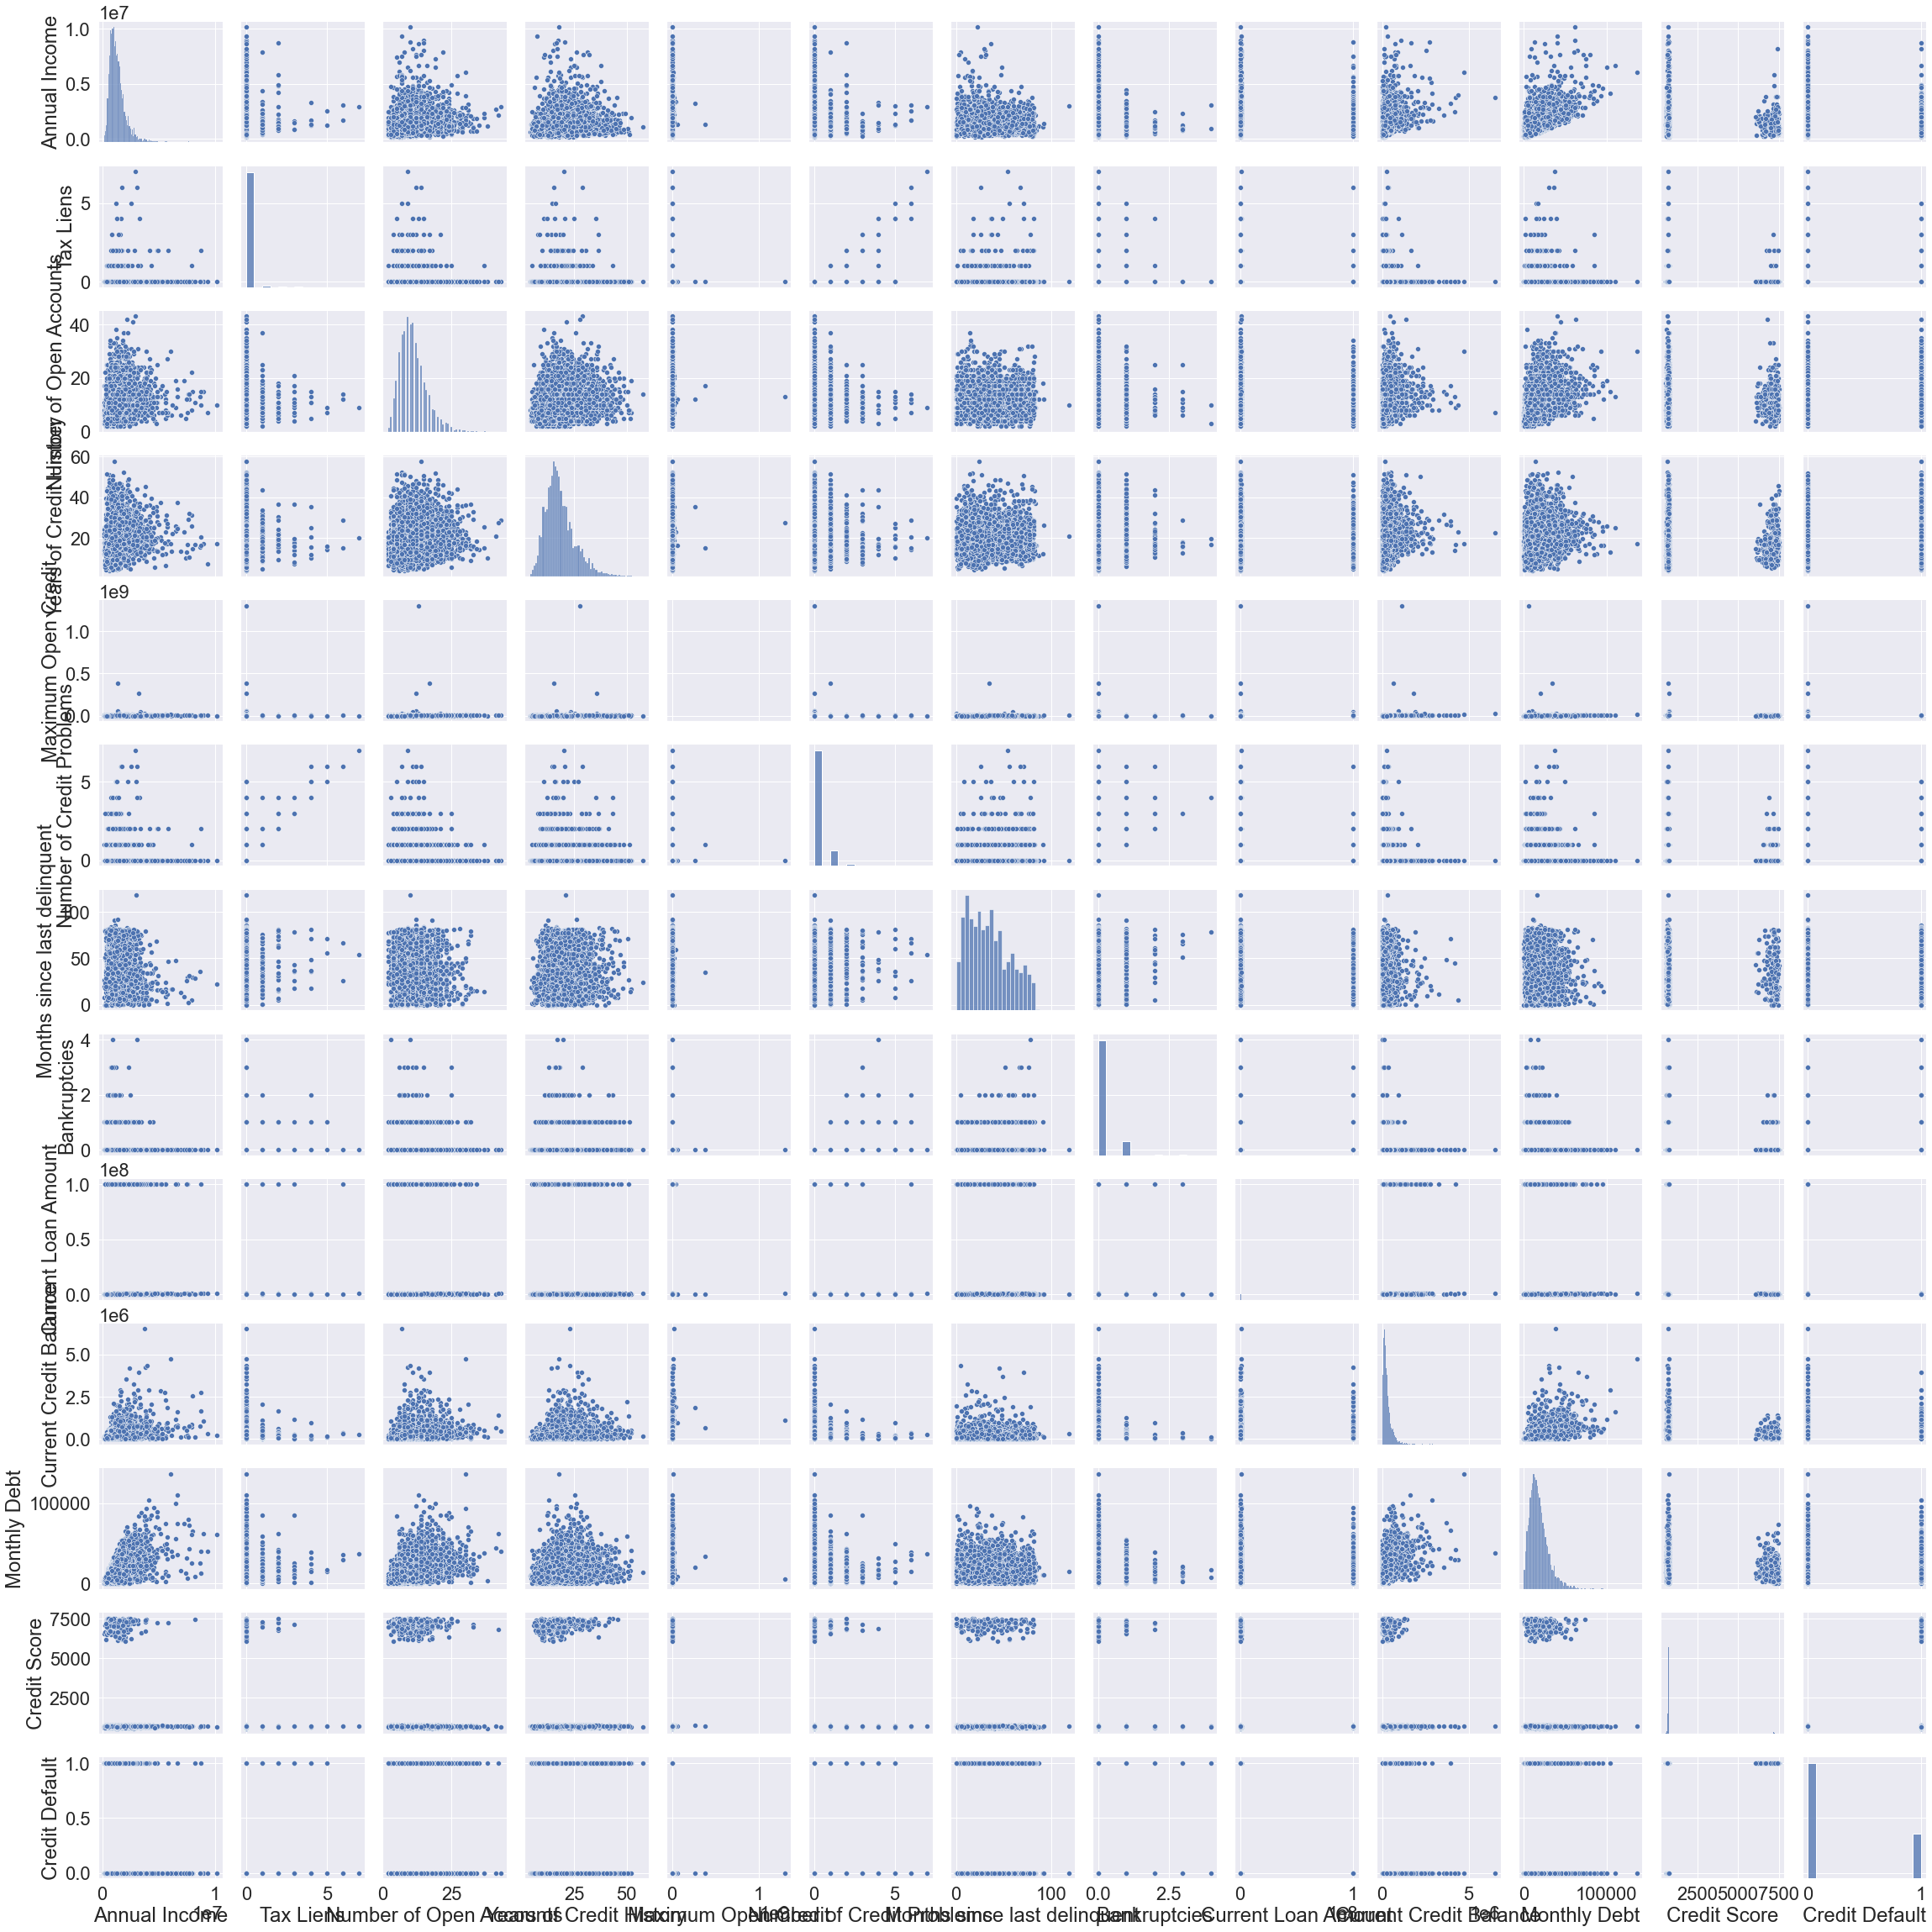

In [178]:
sns.pairplot(df_train)

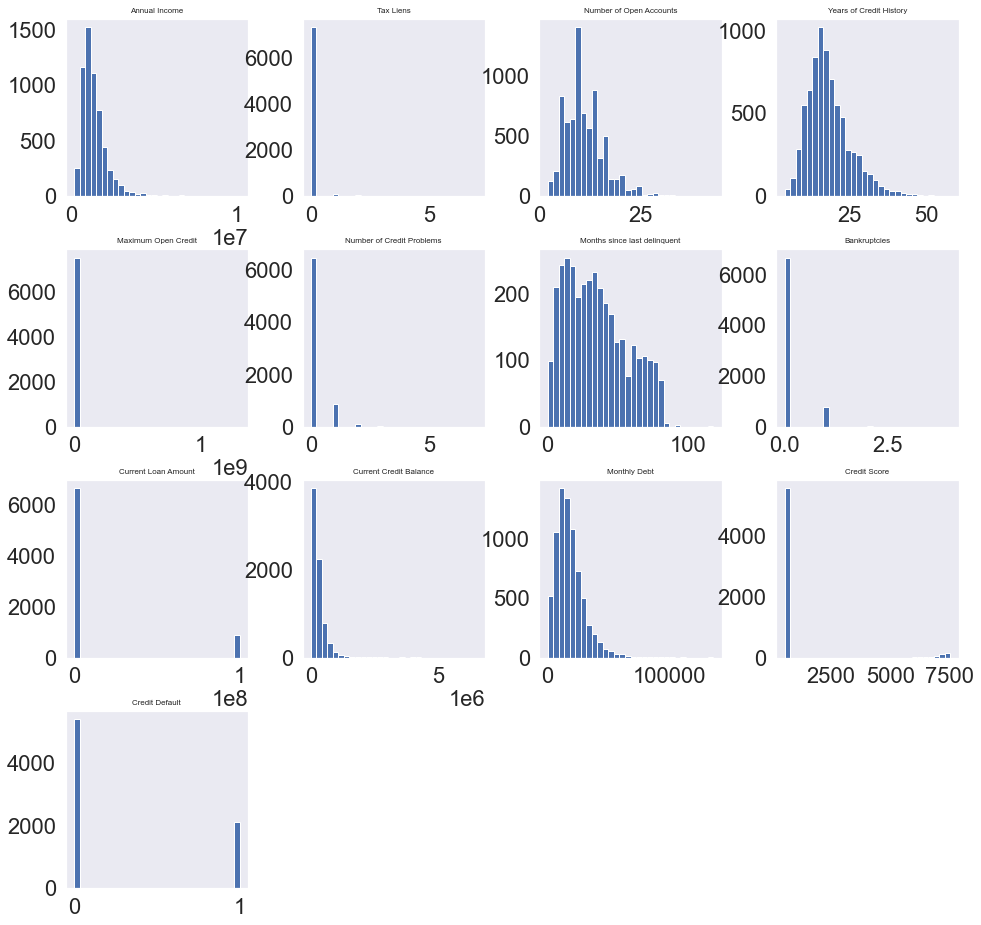

In [177]:
df_train.hist(figsize=(16,16), bins=30, grid=False);

KeyboardInterrupt: 

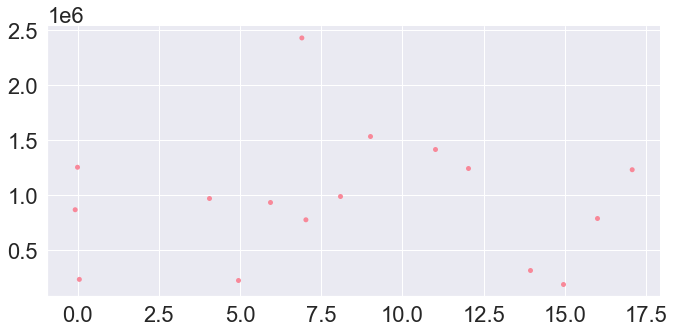

In [161]:
sns.catplot(x="Monthly Debt", y="Annual Income", 
            #kind="box", 
            data=df_train, aspect=2,
           );

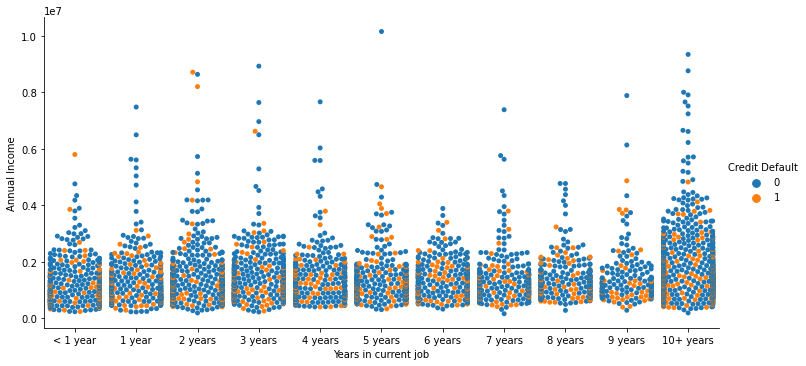

In [112]:
sns.catplot(x="Years in current job", y="Annual Income", hue="Credit Default", 
            kind="swarm", aspect=2, data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

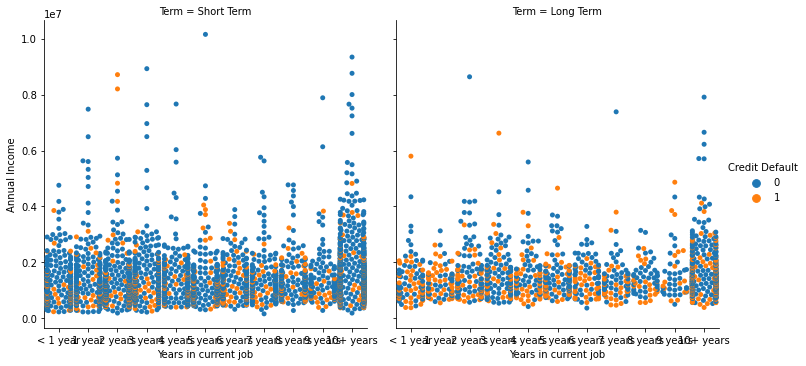

In [113]:
sns.catplot(x="Years in current job", y="Annual Income", 
            hue="Credit Default", col="Term", 
            aspect=1, kind="swarm", data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

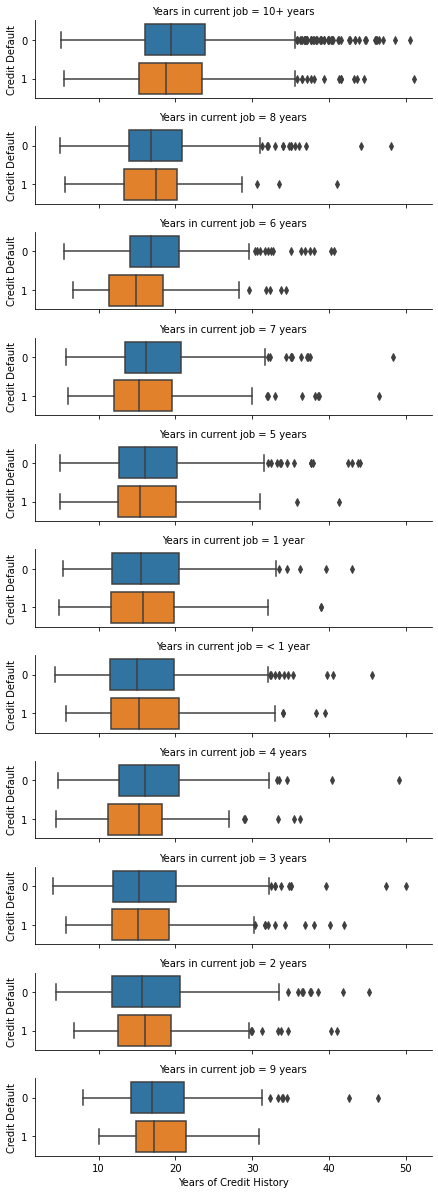

In [106]:
g = sns.catplot(x="Years of Credit History", y='Credit Default', row='Years in current job',
                kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
g.set();
#https://seaborn.pydata.org/tutorial/categorical.html

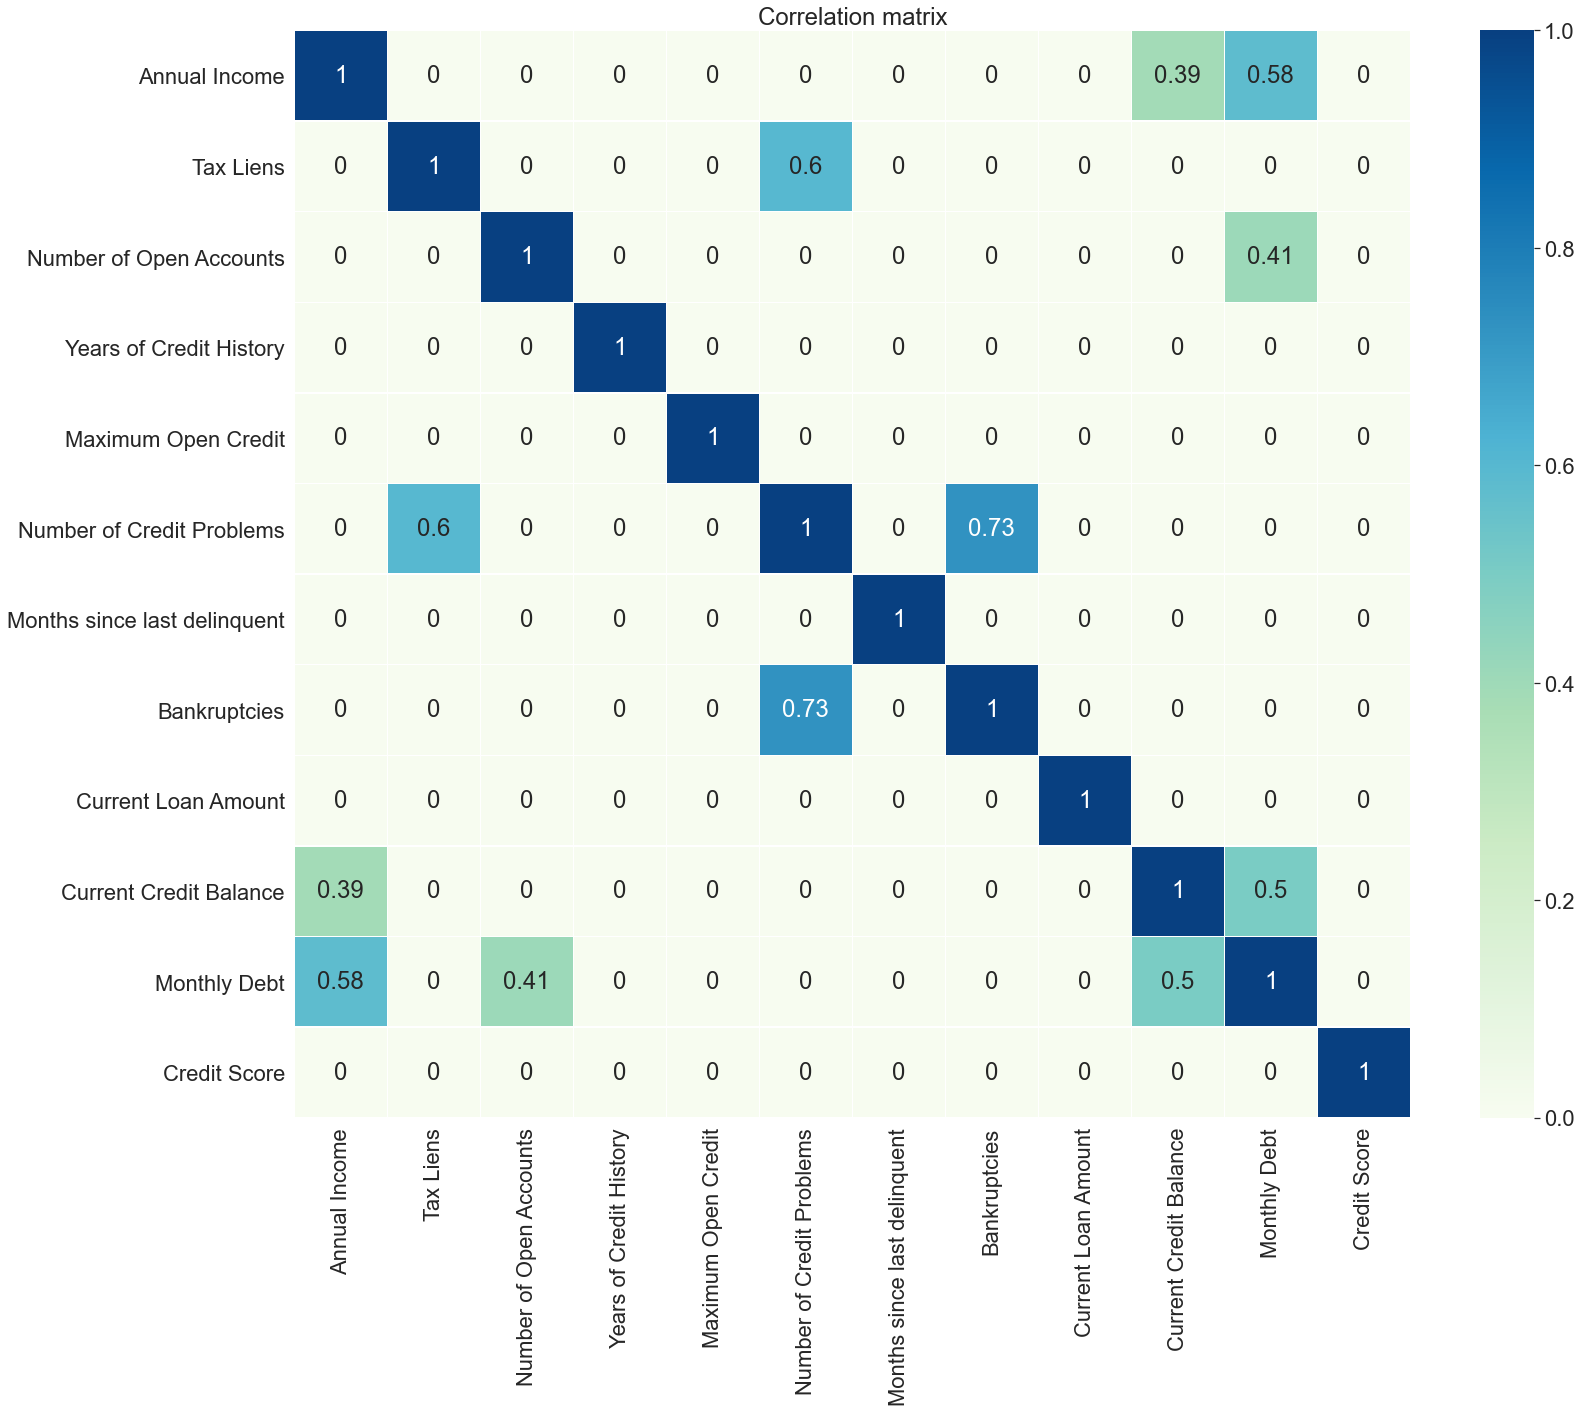

In [159]:
plt.figure(figsize = (25,20))

sns.set(font_scale=2)

corr_matrix = df_train[NUM_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Отбор признаков

# Балансировка классов

In [120]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [121]:
5387/2113

2.549455750118315

Построим модель с весами для разных классов

{'max_depth': 1, 'min_samples_leaf': 1}
Accuracy на трейне 0.772
Accuracy на тесте 0.77
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1087
           1       1.00      0.16      0.28       413

    accuracy                           0.77      1500
   macro avg       0.88      0.58      0.57      1500
weighted avg       0.83      0.77      0.70      1500

F1-score = 0.283
Wall time: 17.9 s


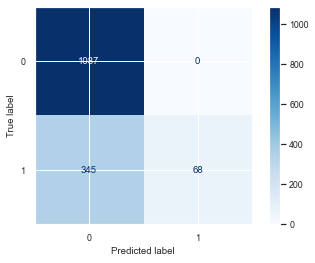

In [126]:
%%time

# Обновляем датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# Заполняем пропуски медианой
df_train = df_train.fillna(df_train.median(axis=0), axis=0)

# Переводим категориальные признаки в количественные
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Формируем выборки
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

# Подбираем гиперпараметры
tree = DecisionTreeClassifier(random_state=1, class_weight={0:1, 1:2.55})

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

print(grid_search.best_params_)

# Предсказываем значения трейновой и тестовой выборки
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

#Подсчитываем метрики
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

print(classification_report(y_test, pred_test))
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

```
class_weight={0:2.55, 1:1}  F1 = 0.294
class_weight={0:1, 1:2.55}  F1 = 0.283
```

# Подбор моделей, получение бейзлана

Обновляем датасет

In [325]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Заполняем пропуски медианой

In [326]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
#df_train = df_train.fillna(df_train.mode()[0:])
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Переводим категориальные признаки в количественные

In [327]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home i

Выделение целевой переменной и групп признаков. Отбор признаков

In [328]:
# все признаки
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

Стандартизация данных

In [329]:
scaler = StandardScaler()

df_train_norm = df_train.copy()
df_train_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUM_FEATURE_NAMES])

df_train = df_train_norm.copy()

Разбиение на train и test

In [330]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [291]:
X_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_1 year',
       'Years in current job_10+ years', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job_< 1 year',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Pur

## Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [292]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.98      0.86      3771
           1       0.82      0.28      0.42      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.63      0.64      5250
weighted avg       0.79      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1616
           1       0.78      0.23      0.36       634

    accuracy                           0.77      2250
   macro avg       0.77      0.60      0.61      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1575   41
1                486  148


**k ближайших соседей**

In [293]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3771
           1       0.78      0.51      0.61      1479

    accuracy                           0.82      5250
   macro avg       0.80      0.73      0.75      5250
weighted avg       0.82      0.82      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1616
           1       0.55      0.32      0.40       634

    accuracy                           0.73      2250
   macro avg       0.66      0.61      0.62      2250
weighted avg       0.71      0.73      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1448  168
1                432  202


**Дерево решений**

Дисбаланс классов

In [294]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [295]:
class_weight = df_train['Credit Default'].value_counts()[1] / df_train['Credit Default'].value_counts()[0]
class_weight

0.39224057917208094

In [296]:
df_train['Credit Default'].value_counts()

5387/2113# class_weight - веса для разных классов т.к. дисбаланс классов.
# В 3,6 раз объектов 1-го класса больше чем нулевого
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:class_weight, 1:1},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.53      0.51      0.52      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.73      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.51      0.49      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1312  304
1                322  312


**Бустинговые алгоритмы**

*XGBoost*

Т.к. в трейне и тесте после перевода в категориальные данные появляется столбец 'Years in current job_< 1 year', то необходимо заменить знак < на _ . Иначе появляется ошибка `ValueError('feature_names may not contain [, ] or <')`

In [297]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_xgb = X_train
X_test_xgb = X_test
X_train_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                   else col for col in X_train.columns.values]
X_test_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                  else col for col in X_test.columns.values]

In [300]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train_xgb, X_test_xgb, y_train, y_test)

[22:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3771
           1       1.00      0.89      0.94      1479

    accuracy                           0.97      5250
   macro avg       0.98      0.94      0.96      5250
weighted avg       0.97      0.97      0.97      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1616
           1       0.60      0.36      0.45       634

    accuracy                           0.75      2250
   macro avg       0.69      0.63      0.65      2250
weighted avg       0.73      0.75      0.73      2250

CONFUSION MATRIX

col_0

*LightGBM*

In [301]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:class_weight, 1:1},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3771
           1       0.84      0.95      0.89      1479

    accuracy                           0.93      5250
   macro avg       0.91      0.94      0.92      5250
weighted avg       0.94      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1616
           1       0.50      0.53      0.51       634

    accuracy                           0.72      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1282  334
1                300  334
Wall time: 159 ms


*CatBoost*

In [331]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     #cat_features=CAT_FEATURE_NAMES
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3771
           1       0.98      0.56      0.71      1479

    accuracy                           0.87      5250
   macro avg       0.92      0.78      0.82      5250
weighted avg       0.89      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1616
           1       0.71      0.32      0.44       634

    accuracy                           0.77      2250
   macro avg       0.74      0.63      0.65      2250
weighted avg       0.76      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1533   83
1                434  200
Wall time: 3.28 s


**Лучший F1-score=0.51 получился на алгоритме LightGBM**

Попробуем настроить CatBoost который с параметрами по умолчанию выдал метрику 0.44.

## Подготовка для catboost

Обновляем датасет

In [155]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [156]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Заполняем пропуски медианой

In [54]:
df_train.fillna(df_train.median(axis=0), inplace=True)
#df_train = df_train.fillna(df_train.mode()[0:])
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [70]:
df_train.fillna(df_train.median(), inplace=True)

In [87]:
df_train.mode().iloc[0]

Home Ownership                       Home Mortgage
Annual Income                               969475
Years in current job                     10+ years
Tax Liens                                        0
Number of Open Accounts                          9
Years of Credit History                         15
Maximum Open Credit                              0
Number of Credit Problems                        0
Months since last delinquent                    14
Bankruptcies                                     0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                           0
Monthly Debt                                     0
Credit Score                                   740
Credit Default                                   0
Name: 0, dtype: object

In [78]:
df_train.iloc[3742:3745, 2:4]

,Years in current job,Tax Liens
3742,< 1 year,0.0
3743,NaN,0.0
3744,8 years,0.0


Выделение целевой переменной и групп признаков. Отбор признаков

In [9]:
# все признаки
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

In [10]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [38]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Term']

In [37]:
X_train.iloc[45:48,12:14]

,Home Ownership,Years in current job
6052,Rent,5 years
3743,Home Mortgage,NaN
2885,Home Mortgage,10+ years


In [14]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     one_hot_max_size=7,
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

CatBoostError: Invalid type for cat_feature[non-default value idx=46,feature_idx=13]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

## Балансировка

In [27]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
# df_balanced[TARGET_NAME].value_counts()
# X_train = df_balanced.drop(columns=TARGET_NAME)
# y_train = df_balanced[TARGET_NAME]
# y_train.value_counts()

0    5464
1    4608
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [28]:
X_train[CAT_FEATURE_NAMES]['PAY_1'].nunique()

5

Для CatBoost не нужно переводить категориальные признаки в числовые. Он сделает это сам.

Но по умолчанию CatBoost воспринимает как категориальные признаки только с 2-мя уникальными значениями. Если признак имеет больше чем 2 уникальных значения, то он будет считаться не категорийным. Параметр one_hot_max_size позволяет изменить это.

In [29]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
#                                      one_hot_max_size=5
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      5464
           1       0.81      0.46      0.59      1536

    accuracy                           0.86      7000
   macro avg       0.84      0.72      0.75      7000
weighted avg       0.85      0.86      0.84      7000

TEST

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2341
           1       0.68      0.37      0.48       659

    accuracy                           0.82      3000
   macro avg       0.76      0.66      0.69      3000
weighted avg       0.81      0.82      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2227  114
1                    413  246


In [30]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

3.5572916666666665

In [31]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      5464
           1       0.60      0.82      0.69      1536

    accuracy                           0.84      7000
   macro avg       0.77      0.83      0.79      7000
weighted avg       0.87      0.84      0.85      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2341
           1       0.49      0.59      0.54       659

    accuracy                           0.78      3000
   macro avg       0.68      0.71      0.69      3000
weighted avg       0.79      0.78      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1938  403
1                    269  390


[Гиперпараметры catboost](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list)

In [32]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
# кол-во итераций для окончания обучения если метрика не начала расти - чтобы не ждать расчётов пока модель переобучается
#                                      early_stopping_rounds=20,
#  сохраняем самую лучшую модель. автоматически становиться True если используем early_stopping_rounds
#                                      use_best_model=True,
#                                      custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
model_catb.best_score_

{'learn': {'Logloss': 0.2734211189583165, 'F1': 0.931501376441783},
 'validation': {'Logloss': 0.5576961309131181, 'F1': 0.6794929684504168}}

In [92]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      5464
           1       0.49      0.65      0.56      1536

    accuracy                           0.78      7000
   macro avg       0.69      0.73      0.71      7000
weighted avg       0.80      0.78      0.79      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2341
           1       0.49      0.61      0.54       659

    accuracy                           0.77      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1925  416
1                    260  399


# Выбор наилучшей модели, настройка гиперпараметров

# Проверка качества, борьба с переобучением

# Интерпретация результатов